In [1]:
suppressMessages(library(scRepertoire))
suppressMessages(library(Seurat))
suppressMessages(library(tidyverse))
suppressMessages(library(ggpubr))
suppressMessages(library(data.table))

In [2]:
setwd('/rd2/user/xiacr/sle/')
# output_path <- './output_file/seurat/plasma/'
# source('./scripts/function_R/utils.R')


In [3]:
load('./final/seurat/plasma/03-plasma_anno_filter_No_harm.rdata')
load('./final/scRepertoire/BCR/combined_bcr.rdata')

In [4]:
ls()

[1] "combined_bcr"  "plasma_filter"

# scRepertoire

In [5]:
# We need to handle the barcode difference between scRepertoire and seurat
head(combined_bcr$GW_SLE$barcode)
# SAMPLE + GROUP + BARCODE
Cells(plasma_filter) %>% head()
scRepertoire_barcode <- plasma_filter@meta.data %>% rownames_to_column('barcode_new')%>% 
    mutate(new_barcode = str_split_fixed(barcode_new ,'_',2)[,1])%>% 
    mutate(scRepertoire=paste0(orig.ident,'_',group,'_',new_barcode) )%>% select(scRepertoire) 

[1] "GW_SLE_CAGGTGCCAGGGCATA-1" "GW_SLE_GAGGTGATCTCTTGAT-1"
[3] "GW_SLE_AACCATGCACCAGTTA-1" "GW_SLE_GGACAAGGTACATGTC-1"
[5] "GW_SLE_TACGGGCTCTCGATGA-1" "GW_SLE_CGTGTCTCATGCATGT-1"

[1] "AAATGCCCATGTTGAC-1_1" "AACACGTCAGCGATCC-1_1" "AACCATGCACCAGTTA-1_1"
[4] "AACTCAGGTATATCCG-1_1" "AACTCTTTCCCTTGCA-1_1" "AACTTTCTCGTTACGA-1_1"

In [8]:
plasma_filter <- RenameCells(plasma_filter, new.names = scRepertoire_barcode$scRepertoire)
bcr_df <- rbindlist(combined_bcr)

In [9]:
intersect(scRepertoire_barcode$scRepertoire , bcr_df$barcode)%>%length()

[1] 3138

In [10]:
plasma_filter <- combineExpression(combined_bcr, plasma_filter, addLabel =T,
            cloneCall="aa", group.by = "sample", proportion = FALSE, 
            cloneTypes=c(Single=1, Small=10, Medium=10, Large=1000))
# plasma_filter <- combineExpression(combined_bcr, plasma_filter, 
#             cloneCall="gene", group.by = "sample", proportion = T,
#             cloneTypes = c(Rare = 1e-04, Small = 0.001, Medium = 0.01, Large = 0.1, Hyperexpanded = 1))
colorblind_vector <- colorRampPalette(rev(c("#0D0887FF", "#47039FFF", 
              "#7301A8FF", "#9C179EFF", "#BD3786FF", "#D8576BFF",
              "#ED7953FF","#FA9E3BFF", "#FDC926FF", "#F0F921FF")))

In [11]:
plasma_filter$Frequency.sample %>% is.na() %>% table()

.
FALSE  TRUE 
 3138    16 

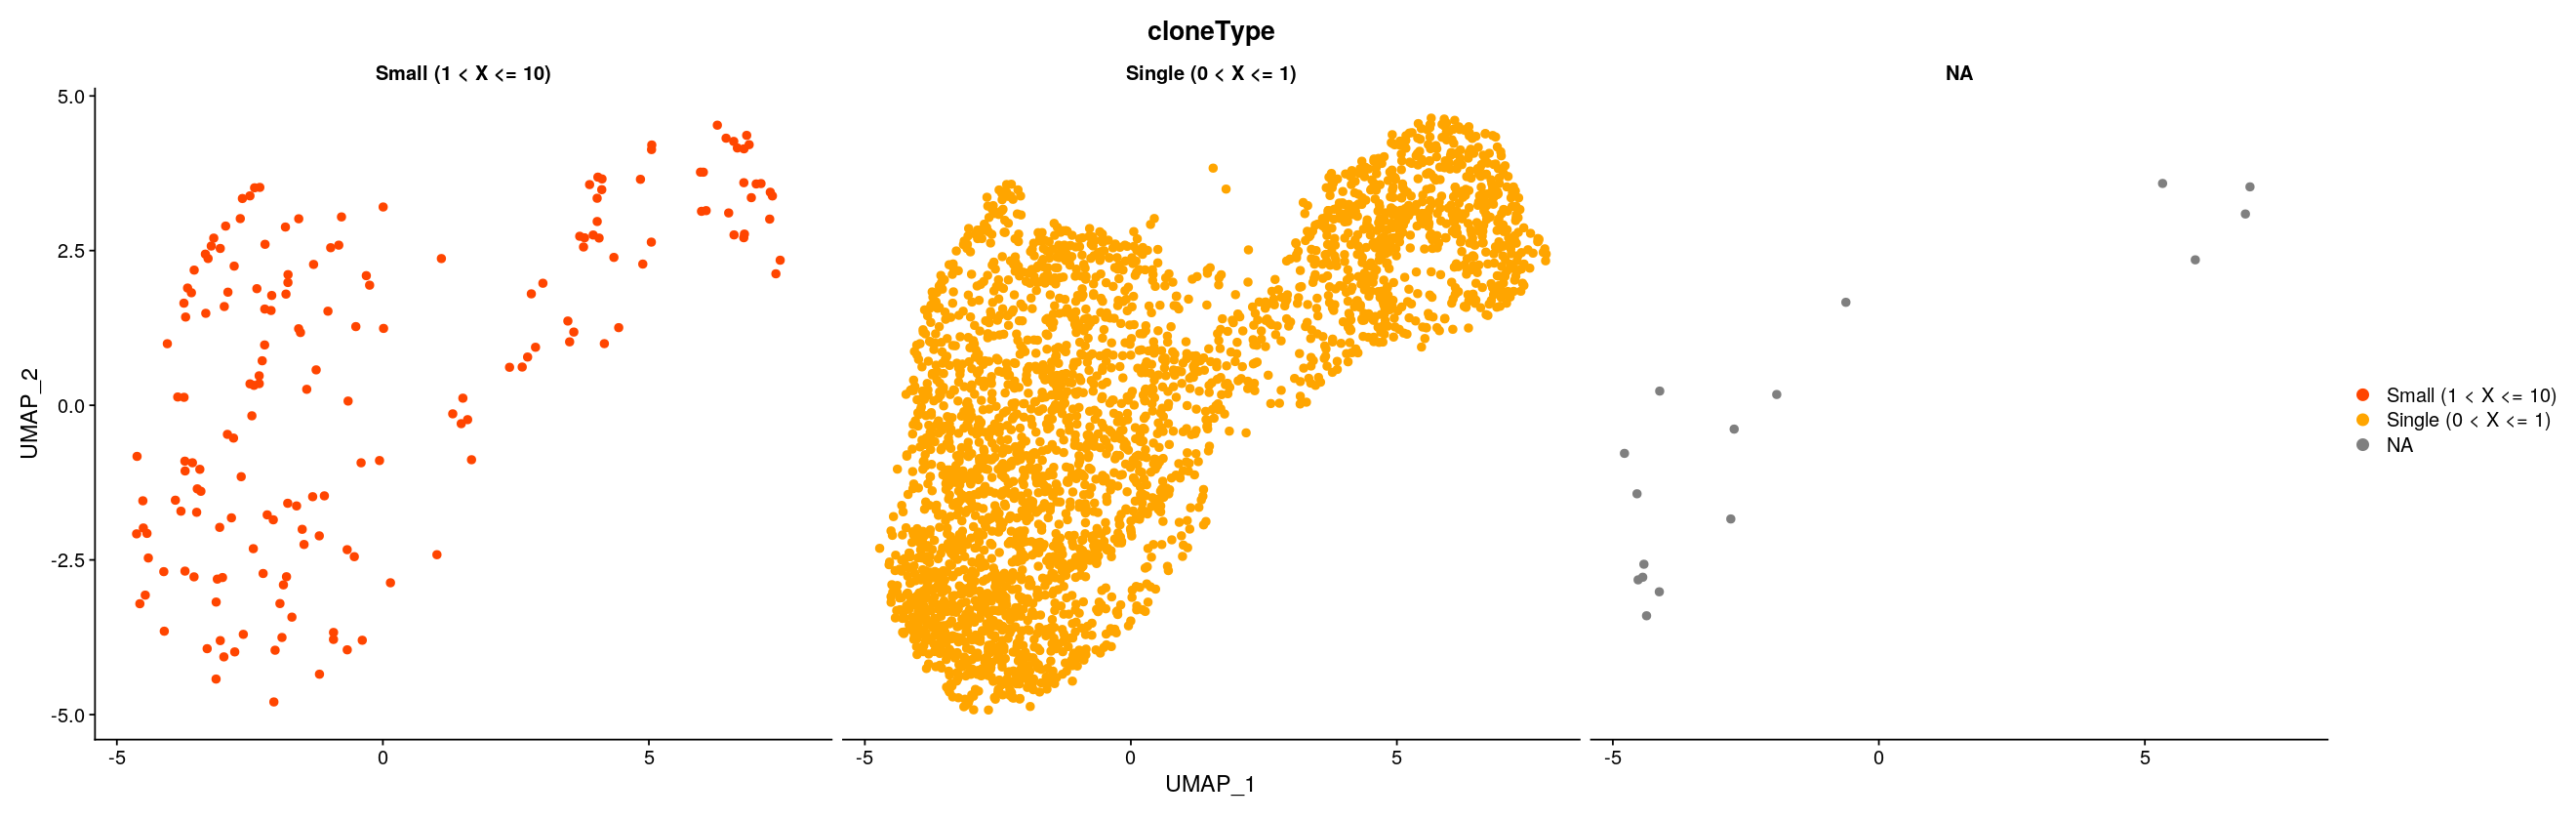

In [12]:
options(repr.plot.width=22, repr.plot.height=7)
slot(plasma_filter, "meta.data")$cloneType <- factor(slot(plasma_filter, "meta.data")$cloneType, 
                levels = c("Large (10 < X <= 1000)", 
                            "Small (1 < X <= 10)", 
                            "Single (0 < X <= 1)", NA))
# slot(plasma_filter, "meta.data")$cloneType <- factor(slot(plasma_filter, "meta.data")$cloneType, 
#                 levels = c("Hyperexpanded (20 < X <= 5000)", 
#                            "Large (10 < X <= 20)", 
#                             "Medium (5 < X <= 10)", 
#                             "Small (1 < X <= 5)", 
#                             "Single (0 < X <= 1)", NA))
DimPlot(plasma_filter, group.by = "cloneType",cols = rev(c('grey','green','blue','#FFA500','#FF4500')), split.by = 'cloneType',pt.size = 2)

In [13]:
Idents(plasma_filter) <- 'cloneType'
plasma_filter_bcr <- subset(plasma_filter, idents = c('Single (0 < X <= 1)','Small (1 < X <= 10)'))
plasma_filter_bcr$cloneType_group <- paste0(plasma_filter_bcr$treatment, '-',plasma_filter_bcr$cloneType)
plasma_filter_bcr$cloneType_group  %>% table()

.
       HC-Single (0 < X <= 1)        HC-Small (1 < X <= 10) 
                          185                            21 
  treated-Single (0 < X <= 1)   treated-Small (1 < X <= 10) 
                          504                            14 
untreated-Single (0 < X <= 1) untreated-Small (1 < X <= 10) 
                         2272                           142 

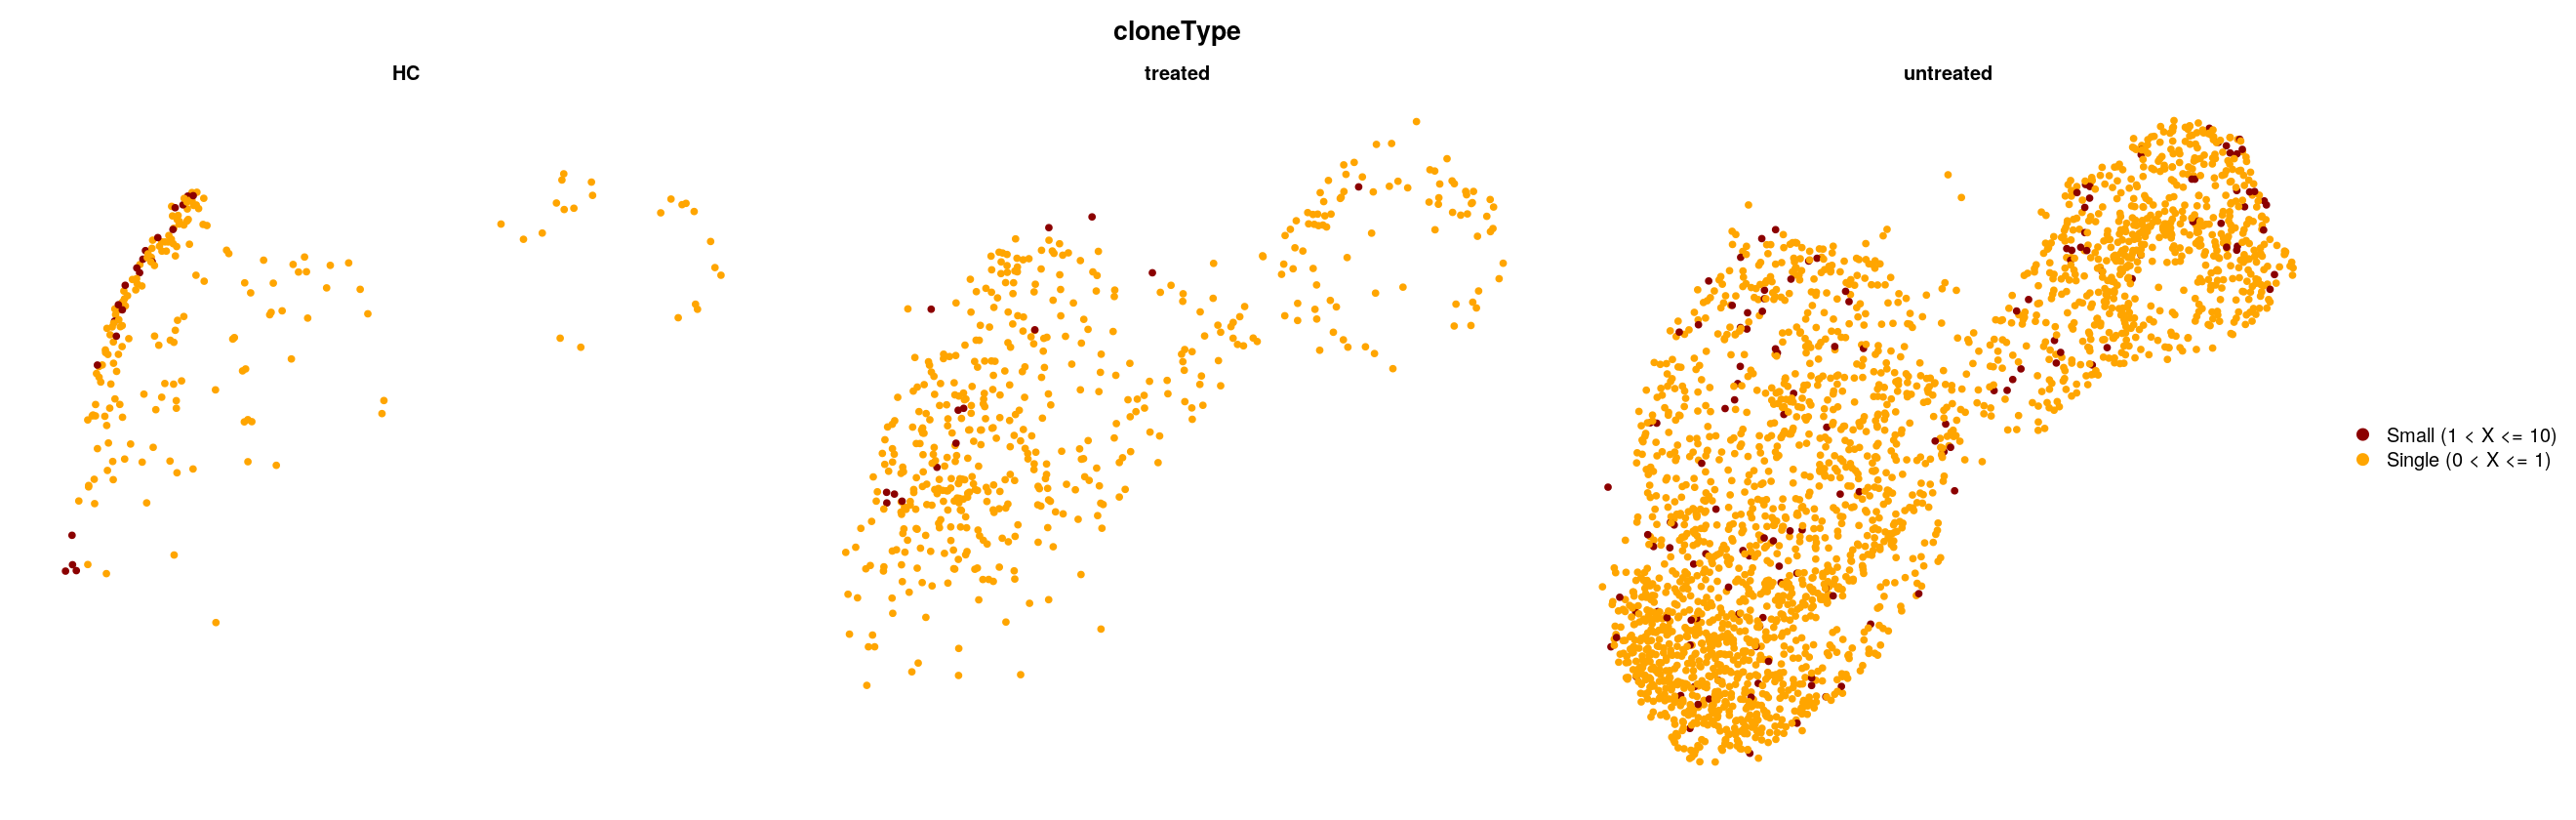

In [14]:
DimPlot(plasma_filter_bcr, group.by = "cloneType",cols = rev(c('#AFEEEE','#FFA500','#8B0000')), split.by = 'treatment',pt.size = 1.5) + NoAxes()

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



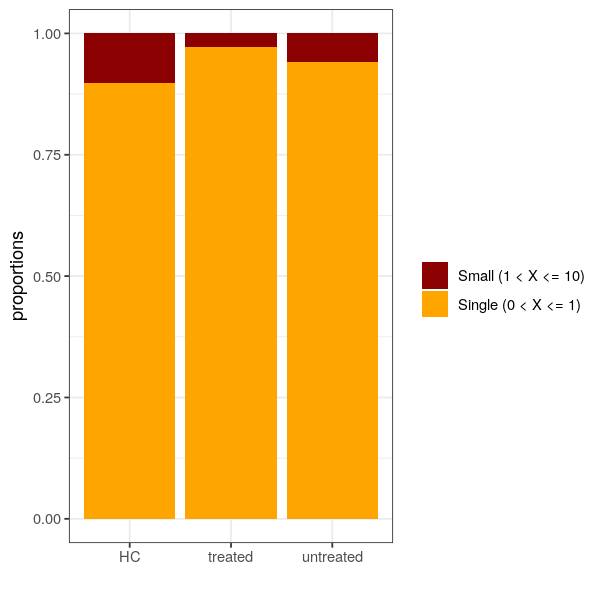

In [15]:
options(repr.plot.width=5, repr.plot.height=5)
ggplot(data = plasma_filter_bcr@meta.data, aes(x = treatment, fill = cloneType))+
    geom_bar(stat = 'count',position = 'fill') + labs(y = 'proportions', x = "") + 
    scale_fill_discrete(labels= names(table(plasma_filter$cloneType))) + xlab('')+
    labs(fill="") +  scale_fill_manual(values= rev(c('#AFEEEE','#FFA500','#8B0000'))) + theme_bw() 

Joining, by = "orig.ident"
Warning message:
“Computation failed in `stat_compare_means()`:
not enough 'x' observations”


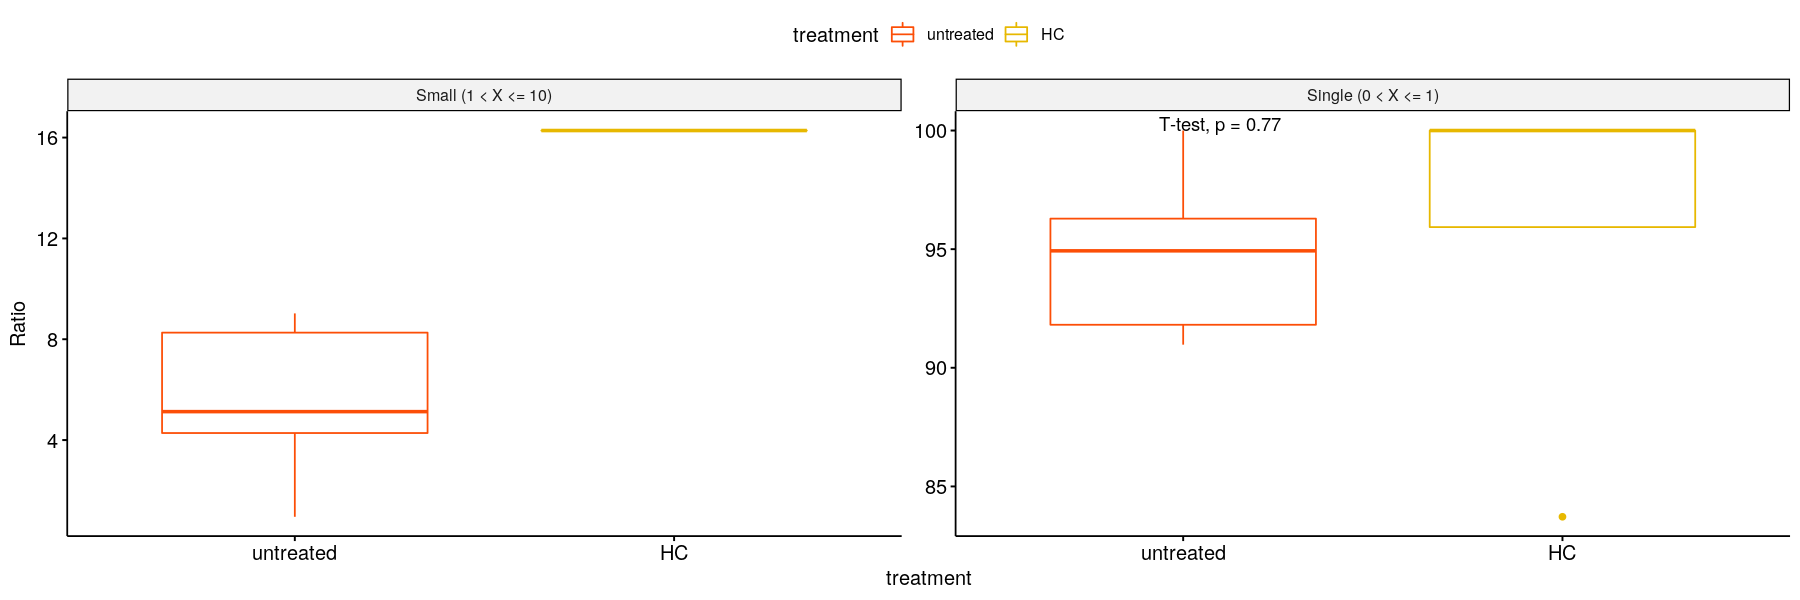

In [16]:
options(repr.plot.width=15, repr.plot.height=5)
plasma_filter_bcr@meta.data  %>% group_by(orig.ident,cloneType) %>% 
    summarise(sub_num = n()) %>% mutate(sample_num = sum(sub_num)) %>% 
    mutate(Ratio = sub_num/sample_num*100) %>%
    left_join(plasma_filter_bcr@meta.data[,c(1,4,5,6)]  %>%  distinct() ) %>%
    filter(treatment != 'treated') %>%
    ggpubr::ggboxplot(x='treatment',y='Ratio', color = 'treatment',
                      palette =c("#FC4E07", "#E7B800", "#00AFBB"))+ 
    facet_wrap(~cloneType,scales = "free",ncol = 4)+ stat_compare_means(method = 't.test')

Joining, by = "orig.ident"
Joining, by = "orig.ident"
Warning message:
“Computation failed in `stat_compare_means()`:
arguments imply differing number of rows: 0, 1”


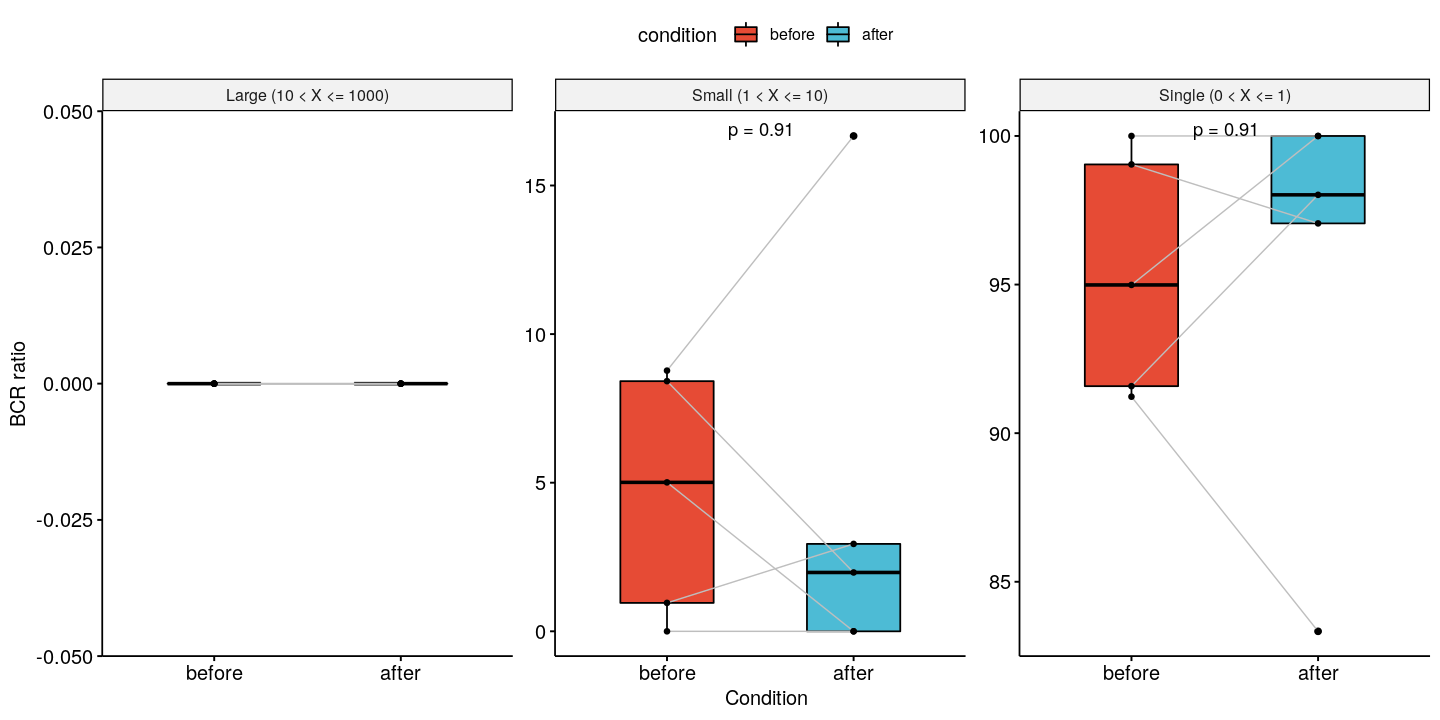

In [17]:
options(repr.plot.width=12, repr.plot.height=6)
tmp1<- plasma_filter_bcr@meta.data  %>% 
    group_by(orig.ident,cloneType,.drop = FALSE) %>% summarise(sub_num = n()) %>% 
    mutate(sample_num = sum(sub_num)) %>% mutate(Ratio = sub_num/sample_num*100) %>%
    left_join(plasma_filter@meta.data[,c(1,4,5,6)]  %>%  distinct()) %>%
    filter(!pair == 'unpaired') %>% filter(treatment =='treated')%>% 
    filter(!orig.ident == 'XYY2')  
tmp2<- plasma_filter_bcr@meta.data  %>% 
    group_by(orig.ident,cloneType,.drop = FALSE) %>% summarise(sub_num = n()) %>% 
    mutate(sample_num = sum(sub_num)) %>% mutate(Ratio = sub_num/sample_num*100) %>%
    left_join(plasma_filter@meta.data[,c(1,4,5,6)]  %>%  distinct()) %>%
    filter(!pair == 'unpaired') %>% filter(treatment =='untreated')%>% 
    filter(!orig.ident == 'XYY2')
data.frame(sample = tmp1$orig.ident, subtype= tmp1$cloneType, 
           before=tmp2$Ratio, after=tmp1$Ratio ) %>%
    # mutate(across(subtype,factor, levels = c("B.transition","B.naive","B.IFN-response",
    #                                          "B.mem.IGHM+","B.mem","B.mem.CXCR3+","B.mem.CD27-"))) %>%
    ggpaired( cond1 = 'before', cond2 = 'after',
              fill  = "condition", line.color = "gray", line.size = 0.4,
              palette = "npg") +  stat_compare_means(paired = TRUE, method = 't.test',label.x = 1.4,label = 'p.format')+
    ylab('BCR ratio') + facet_wrap(~subtype,scales= "free",ncol = 4 )

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


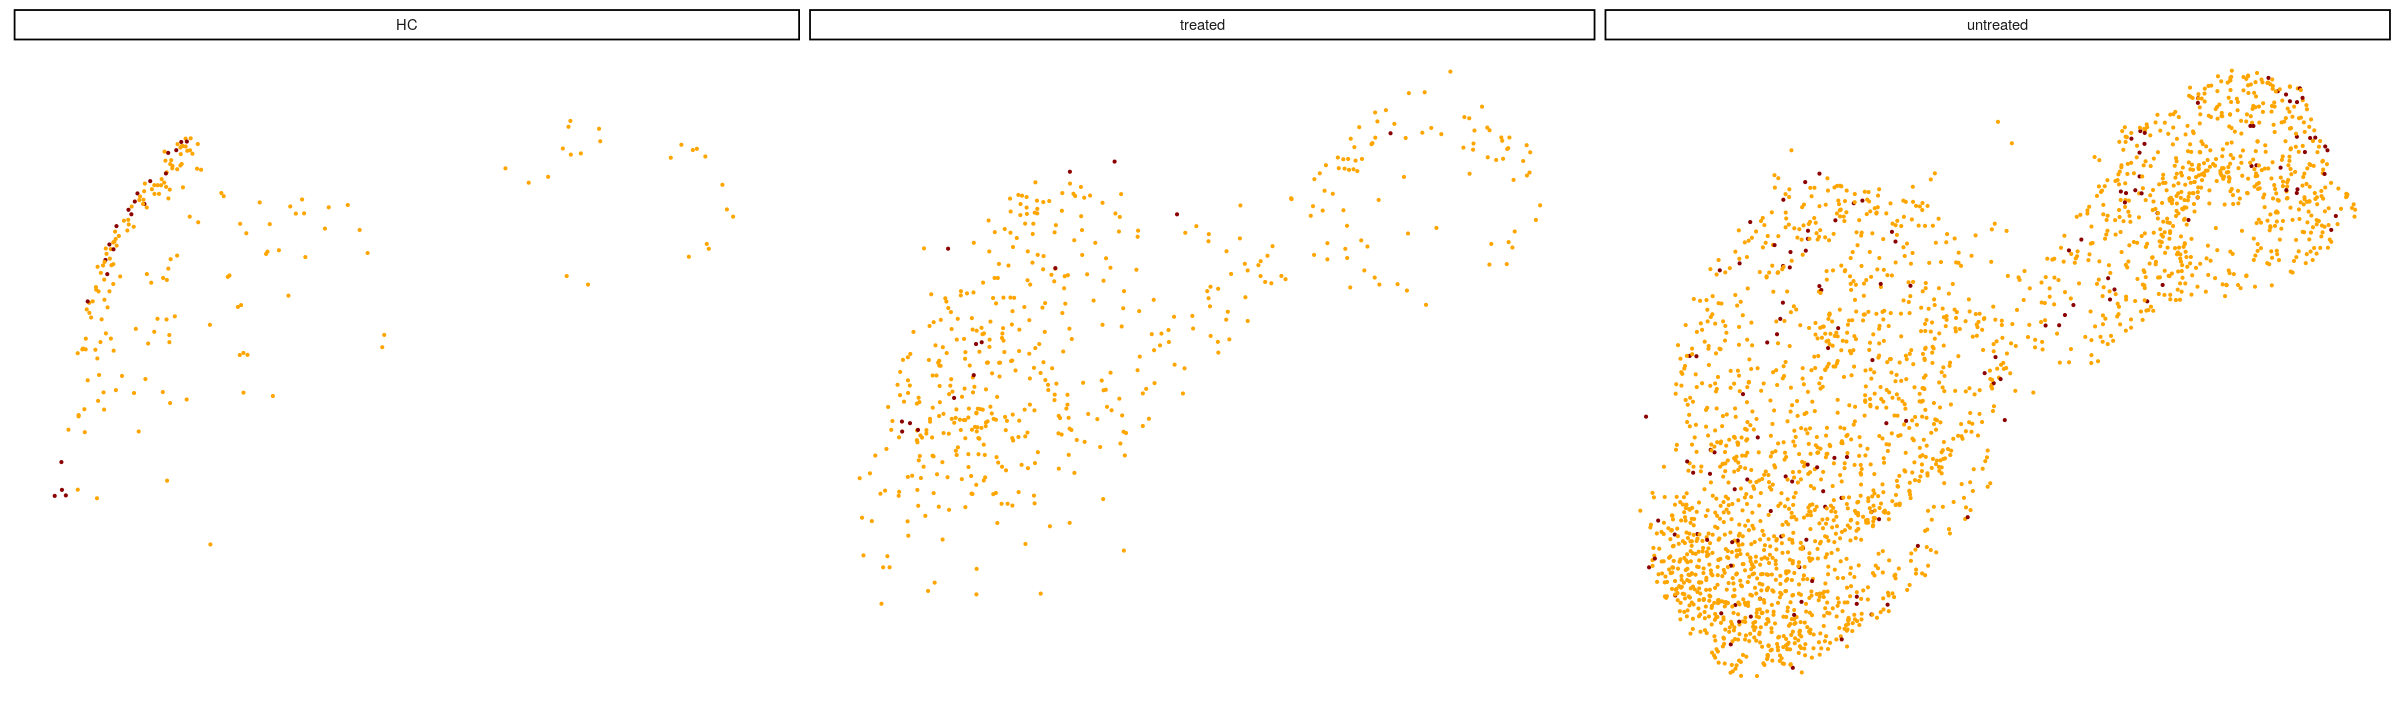

In [18]:
# Idents(bcr_plasma) <- 'cloneType'
options(repr.plot.width=20, repr.plot.height=6)
clonalOverlay(plasma_filter_bcr, reduction = "umap", 
              freq.cutpoint = 7, bins =6, facet = "treatment") + 
    guides(color = FALSE) +scale_color_manual(values= rev(c('#AFEEEE','#FFA500','#8B0000'))) + NoAxes()


# scRepertiore diversity

In [100]:
combined_bcr <- addVariable(combined_bcr, name = "group", 
                       variables = c("before", "before","before","after", "before", "before", "before", "after", "before", "HC", "before",
                                     "before", "after","before", "before", "after", "after", "HC", "HC","before", "after", "HC"))

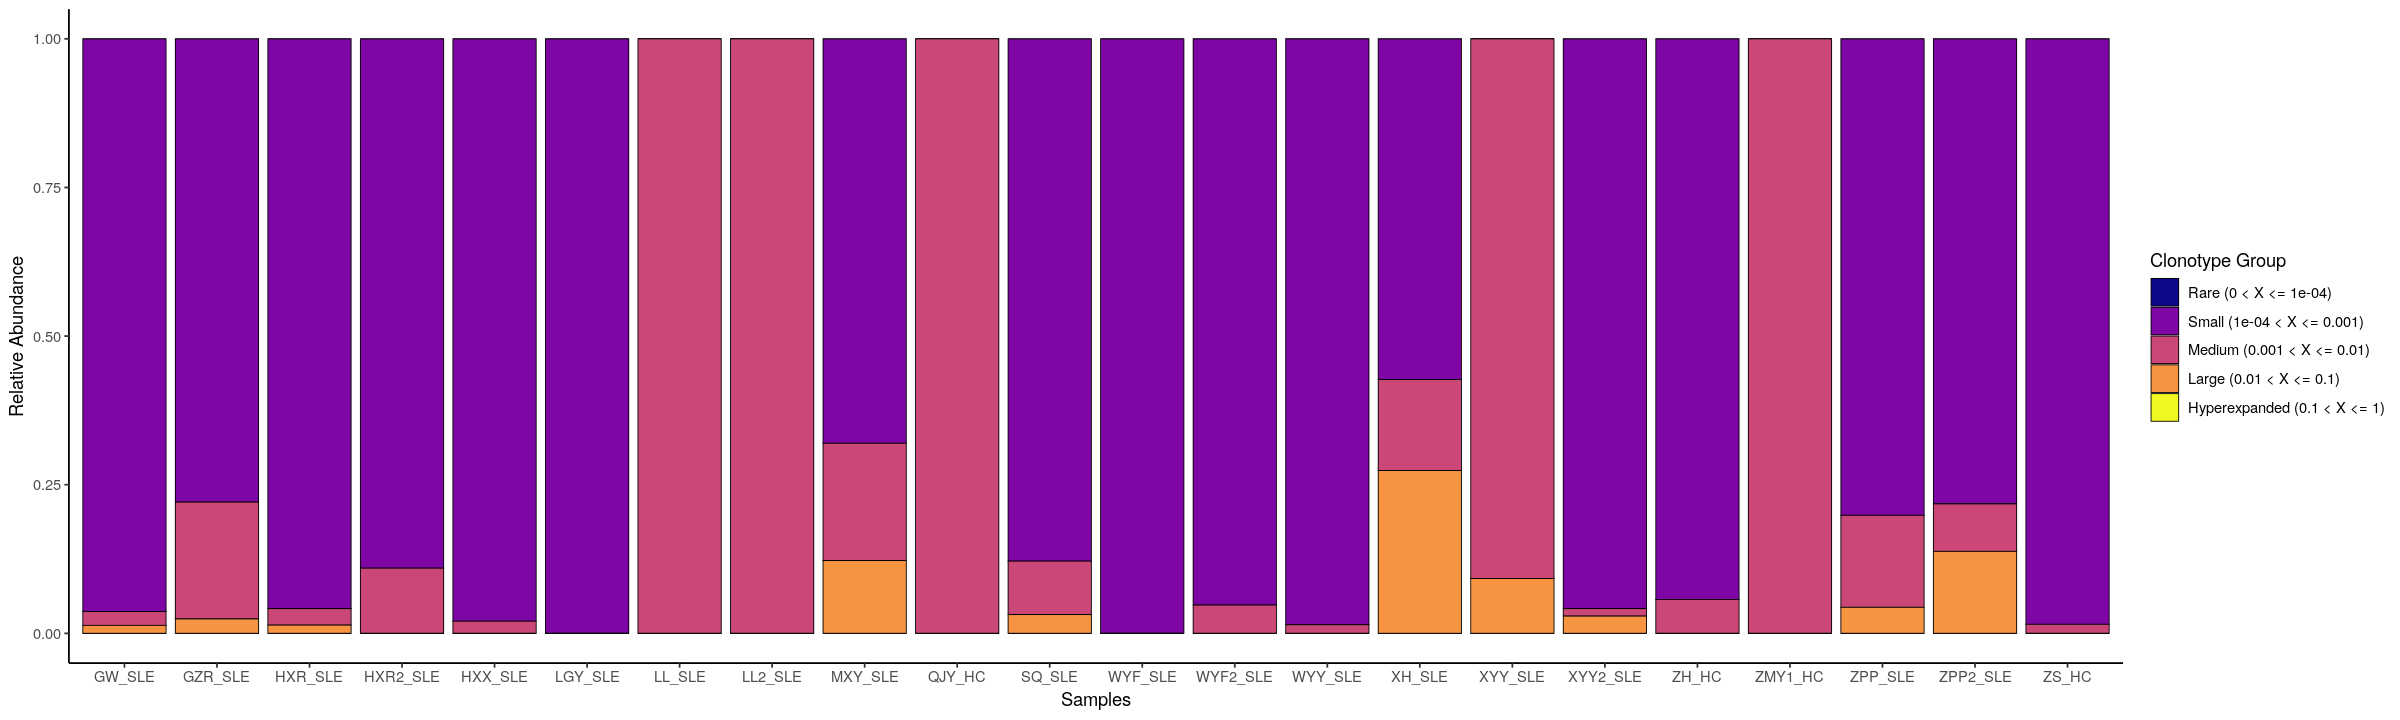

In [103]:
clonalHomeostasis(combined_bcr, cloneCall = "aa")

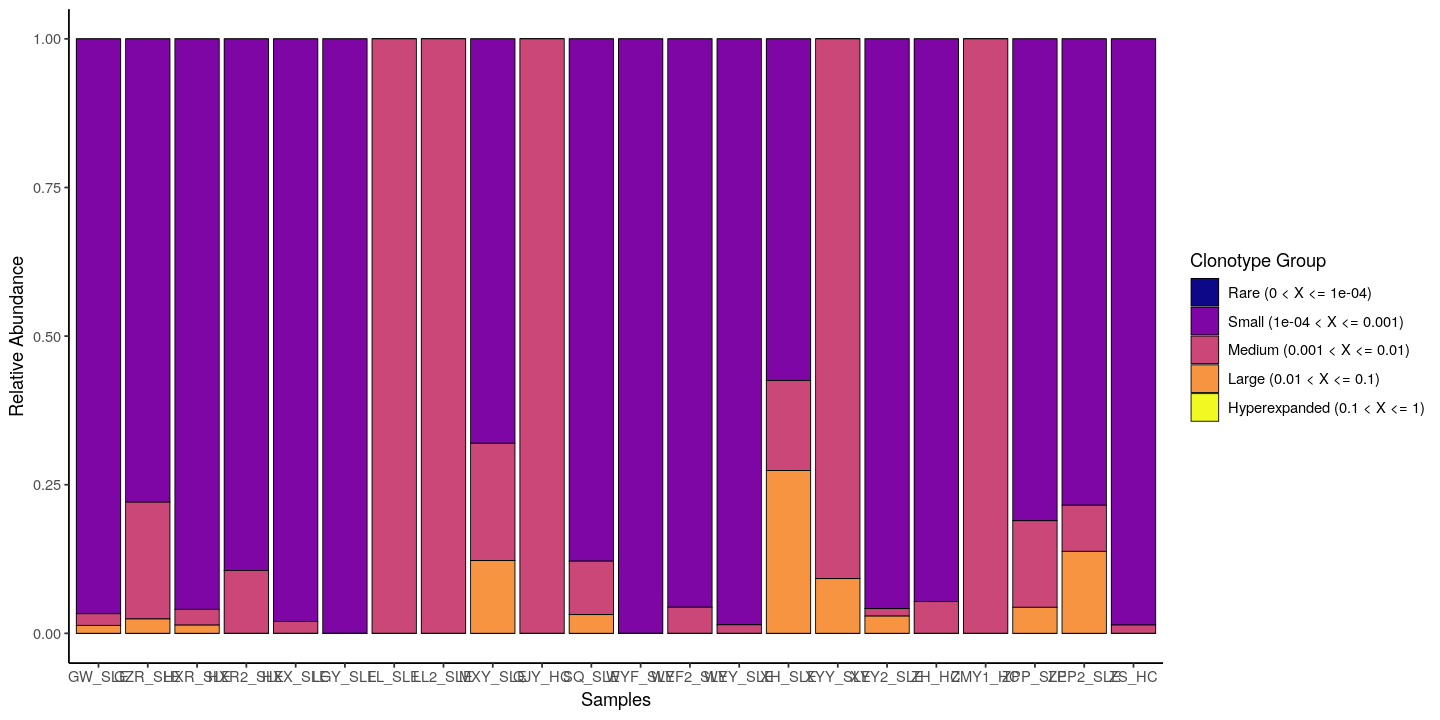

In [114]:
options(repr.plot.width=12, repr.plot.height=6)
clonalHomeostasis(combined_bcr, cloneCall = "nt")

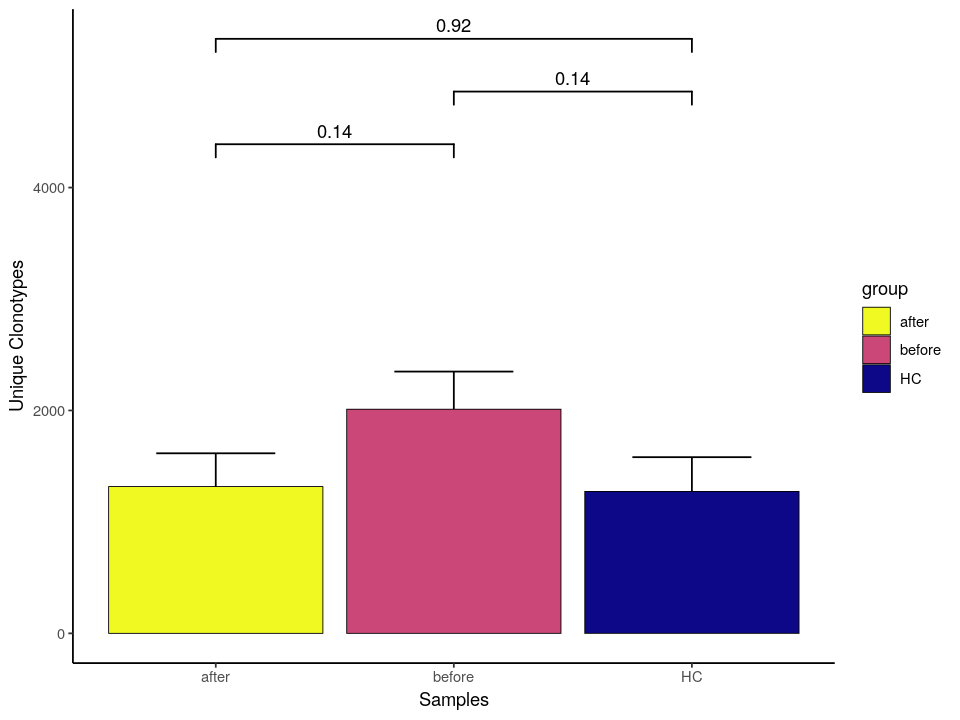

In [115]:
options(repr.plot.width=8, repr.plot.height=6)
quantContig(, cloneCall="aa", scale = F, chain = "both",group.by = 'group') + 
    stat_compare_means(comparisons =  list(c("after", "before"),c('before','HC'),c('after','HC')),  method = "t.test",
                       bracket.size = 0.5)

In [106]:
combined_bcr$GW_SLE$group %>% unique()

[1] "before"

# SHM information

In [19]:
SHM_info <- read.csv('./scripts/immcantaion/bcell_immacantation_SHM.csv')
SHM_info$barcode <- str_split_fixed(SHM_info$sequence_id, pattern = '_',n = 2)[,1] %>% 
    paste0('_',SHM_info$sample)

In [23]:
plasma_filter_bcr$barcode_shm <-  paste0(str_split_fixed(Cells(plasma_filter_bcr), pattern = '_',n = 3)[,3] ,'_',plasma_filter_bcr$orig.ident)

In [24]:
intersect(SHM_info$barcode, plasma_filter_bcr$barcode_shm) %>% length()

[1] 3060

In [28]:
shm_df <- plasma_filter_bcr@meta.data %>% left_join(SHM_info, by = c('barcode_shm' = 'barcode')) %>%
    drop_na(mu_freq_seq_r) %>% drop_na(cloneType)

Warning message:
“Ignoring unknown parameters: trim”


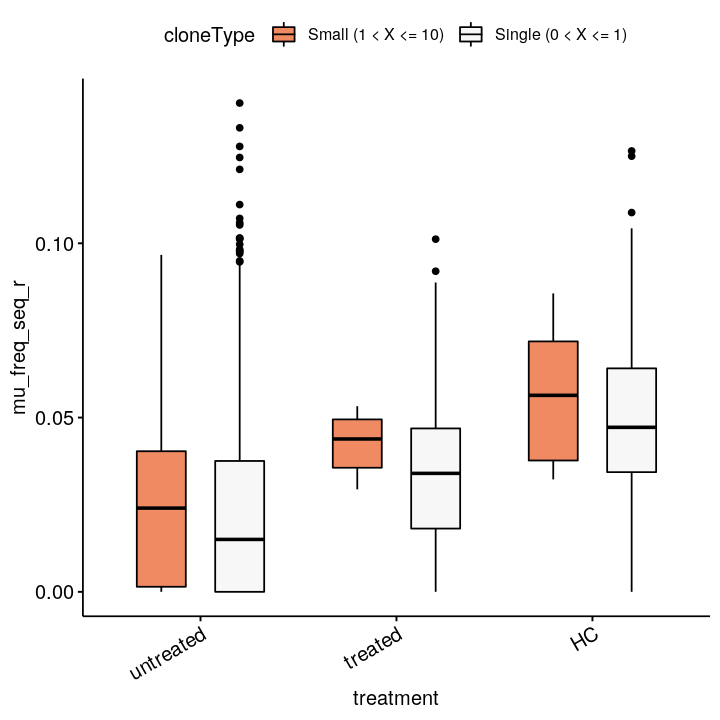

In [31]:
options(repr.plot.width=6, repr.plot.height=6)
compare_group <-  list(c('HC','untreated'),c('treated','untreated'),c('HC','treated'))
shm_df  %>%
# filter(Frequency !=1) %>%
ggboxplot( x = 'treatment', y = 'mu_freq_seq_r',fill = 'cloneType' ,trim = T, width = 0.5, palette = 'RdBu')   +
    # stat_compare_means(mapping = aes(treatment),label = "p.signif",hide.ns = F) +
    # stat_compare_means(mapping = aes(treatment),label = "p.signif",hide.ns = F,comparisons =compare_group) +
    theme(axis.text.x=element_text(angle=30, hjust=1),)

In [83]:
dim(bcr_df)

[1] 41295    15

In [32]:
write.csv(plasma_filter@meta.data, file = 'scripts/conga/BCR/all/seurat_plasma_filter_meta.csv')